# Background noise and source noise
Here we denote the signal-to-noise ratio (SNR) as $r_0$ and
$$\tag{1}
r_0=\frac{F}{\sqrt{F+B}}\,,
$$
where $F$ is the flux within a $5\times5$ pixels square region near the centroid of a galaxy, and $B$ 
is the **flux of a flat sky background in the square region**. Taking the power on both side of 
equaiton (1), we have
$$\tag{2}
r_0^2=\frac{F^2}{F+B}
$$

We denote the ratio between the galaxy flux and the **background flux** in the square region as $r_1=\frac{F}{B}$, 
which quantifies the ratio between the noise contribution from source versus that from background in the square 
region. Then we substitute it into equation (2):
$$
r_0^2=\frac{F r_1}{1+r_1}\,
$$
and we have
$$\tag{3}
F=r_0^2(1+r_1)/r_1\,.
$$
Here we fix the value of $r_0=20$. We change the value of $r_1$ and use equation (3) to determine the
value of galaxy flux $F\,$. The following figure shows the relation between $F$ and $r_1$ in equation (3).

__Note: here $B$ is the flux of background in a square region with $5\times5$ pixels; therefore the pixel 
value of the flat background is $B/25$.__

Text(0, 0.5, '$F$')

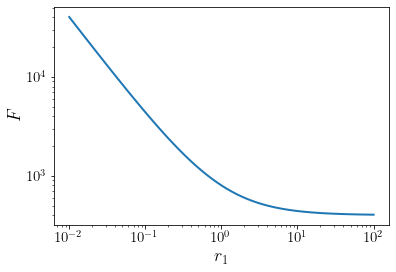

In [1]:
%matplotlib inline
import numpy as np

r1=np.logspace(start=-2,stop=2.,num=100)
r0=20.
F=r0**2.*(1+r1)/r1
B=F/r1
plt.close()
plt.plot(r1,F)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r_1$')
plt.ylabel(r'$F$')

The following function shows how to simulate a galaxy from an input $r_1$ with a fixed $r_0=20\,.$

In [13]:
import galsim
def make_gal_ssbg(shear,psf,rng,r1,r0=20.)->np.ndarray:
    """
    simulate an exponential object with moffat PSF, given a SNR (r0) and
    a source background noise ratio (r0)
    Parameters
    ----
    shear:  (g1, g2)
        The shear in each component
    rng:    np.random.RandomState
        The random number generator
    r1:     float
        The source background noise variance ratio
    r0:     float
        The SNR of galaxy
    psf:    galsim.Moffat, e.g.,
        galsim.Moffat(beta=2.5,fwhm=psf_fwhm,).shear(g1=0.02, g2=-0.01,)
    """
    rng     =   rng
    scale   =   0.263
    gal_hlr =   0.5

    dy, dx  =   rng.uniform(low=-scale/2, high=scale/2, size=2)

    obj0    =   galsim.Exponential(
        half_light_radius=gal_hlr,
    ).shear(
        g1  =   shear[0],
        g2  =   shear[1],
    ).shift(
        dx  =   dx,
        dy  =   dy,
    )
    obj     =   galsim.Convolve(psf, obj0)

    # define the psf and psf here which will be repeatedly used
    psf     =   psf.drawImage(scale=scale).array
    # galaxy image:
    img     =   obj.drawImage(scale=scale).array
    ngrid   =   img.shape[0]
    # noise image:
    noimg   =   rng.normal(scale=1.,size=img.shape)
    # get the current flux using the 5x5 substamps centered at the stamp's center
    flux_tmp=   np.sum(img[ngrid//2-2:ngrid//2+3,ngrid//2-2:ngrid//2+3])
    # the current (expectation of) total noise std on the 5x5 substamps is 5 since for each
    # pixel, the expecatation value of variance is 1; therefore, the expectation value of variance is 25...
    std_tmp =   5
    # normalize both the galaxy image and noise image so that they will have
    # flux=1 and variance=1 (expectation value) in the 5x5 substamps
    img     =   img/flux_tmp
    noimg   =   noimg/std_tmp
    # now we can determine the flux and background variance using equation (3)
    F       =   r0**2.*(1+r1)/r1
    B       =   F/r1
    # multiply the normalized image by F so that it has flux=F in the 5*5 region
    img     =   img*F
    #----Correction start from here 
    # The flat background value at each pixel is
    Bpix    =   B/25. # we have 5x5 pixles in the square region
    # get the variance map of the total noise (source+ background)
    totvar  =   Bpix+img
    # multiply the normalized noise (with variance=1) by the std map of noise from both source and background 
    # at each pixel level
    noimg   =   noimg*np.sqrt(totvar)
    img     =   img+noimg
    #----correction end
    return img,noimg

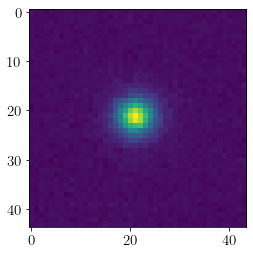

In [18]:
psf_fwhm=   0.9
shear_true = [0.03, 0.00]
rng     =   np.random.RandomState(11)
psf     =   galsim.Moffat(beta=2.5,fwhm=psf_fwhm).shear(g1=0.02, g2=-0.01,)
r1      =   10# a background dominated situation
gal,noimg=   make_gal_ssbg(shear_true,psf,rng,r1,r0=20.)
plt.imshow(gal)

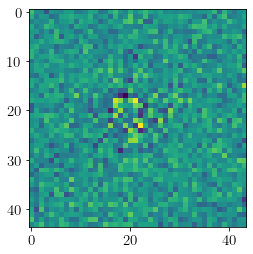

In [19]:
plt.imshow(noimg)